In [15]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import math
import os
import torch
import torch.nn as nn

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
root = "D:\_Files\Shen_Lab\Cytometry\omiq_exported_data_processed"

In [5]:
def global_extrema(dir_name):
    """Return the global maxima and minima of Ir191Di___191Ir_DNA1 and
       Event_length in all the files under the given directory."""
    # The following helper function returns the relavant maxima and minima
    # for a specific file
    def local_extrema(filename):
        data = pd.read_csv(os.path.join(dir_name, filename))
        ir191 = data["Ir191Di___191Ir_DNA1"]
        el = data["Event_length"]
        return (ir191.max(), ir191.min(), el.max(), el.min())
    ir191_max, el_max = -math.inf, -math.inf
    ir191_min, el_min = math.inf, math.inf
    # find the global maxima and minima for the two parameters across
    # all the files in the directory
    for file in os.listdir(dir_name):
        ir191_max_l, ir191_min_l, el_max_l, el_min_l = local_extrema(file)
        ir191_max = max(ir191_max, ir191_max_l)
        ir191_min = min(ir191_min, ir191_min_l)
        el_max = max(el_max, el_max_l)
        el_min = min(el_min, el_min_l)
    return (ir191_max, ir191_min, el_max, el_min)

In [4]:
ir191_max, ir191_min, el_max, el_min = global_extrema(root)
print(f" ir191_max = {ir191_max}\n ir191_min = {ir191_min}\n el_max = {el_max}\n el_min = {el_min}")

 ir191_max = 10.263
 ir191_min = 0.0
 el_max = 174
 el_min = 10


In [6]:
def axes_convert(df_numpy):
    """Convert the axes according to the following rules:
       ir191: int(ir191 * 10000 // 622)
       el: int(el - 10)"""
    for idx in range(df_numpy.shape[0]):
        ir191, el, gate1 = df_numpy[idx]
        ir191 = ir191 * 10000 // 622
        el = el - 10
        gate1 = gate1
        df_numpy[idx] = np.array((ir191, el, gate1))
    return df_numpy

In [7]:
def convert_to_image(filename, highlight=False):
    """Read a data file and output a shrinked greyscale image for the dataset.
       The output image is a numpy array of shape (166, 166, 1).
       To visualise the gate, set highlight to True. For training purpose, set to False.
       """
    image = np.zeros((166, 166, 1))
    data = pd.read_csv(os.path.join(root, filename))[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    data = axes_convert(data.to_numpy())
    # for each cell in the dataset, we convert the axes by the rules described above
    for cell in data:
        ir191, el, gate1 = cell
        # need to make sure these variables are integers
        ir191, el, gate1 = int(ir191), int(el), int(gate1)
        if highlight:
            if gate1 == 0:
                image[ir191, el, 0] = 128
            elif gate1 == 1:
                image[ir191, el, 0] = 255
        else:
            image[ir191, el, 0] += 1
    return image

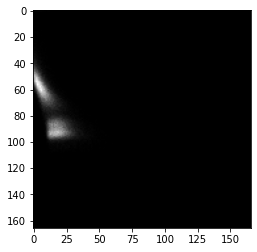

In [21]:
test_image = convert_to_image("49.T1_Normalized.csv")
plt.imshow(test_image, cmap="gray")
del test_image

In [13]:
def convex_hull_vertices(filename):
    """Read a data file and return a list of 10 vertices that define a polygon
       approximating the convex hull (heptagon) of the in-gate data points."""
    # The following code segment computes the convex hull
    data = pd.read_csv(os.path.join(root, filename))[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    in_gate1 = data[data["gate1_ir"] == 1]
    in_gate1 = in_gate1[["Ir191Di___191Ir_DNA1", "Event_length"]].to_numpy()
    hull = ConvexHull(in_gate1)
    # The following code segment extracts the vertices of the convex hull
    vertices = []
    for vertex in hull.vertices:
        vertices.append(tuple(in_gate1[vertex]))
    # The following code segment reduces the number of vertices to 10
    vertex_slope_diff = {}
    num_vertices = len(vertices)
    for j in range(num_vertices):
        i, k = (j - 1) % num_vertices, (j + 1) % num_vertices
        slope1 = (vertices[j][1] - vertices[i][1]) / (vertices[j][0] - vertices[i][0])
        slope2 = (vertices[k][1] - vertices[j][1]) / (vertices[k][0] - vertices[j][0])
        vertex_slope_diff = dict(sorted(vertex_slope_diff.items()))
        reduced_vertices_idx = list(vertex_slope_diff.values())[-10:]
        reduced_vertices = []
        for idx in reduced_vertices_idx:
            reduced_vertices.append(vertices[idx])
    return reduced_vertices

In [14]:
for f in os.listdir(root):
    image = convert_to_image(f, True)
    filename = f[:-4]
    np.save(f"D:\_Files\Shen_Lab\Cytometry\gate_1\plots\highlighted\{filename}.npy", image)
    del image

In [14]:
for f in os.listdir(root):
    image = convert_to_image(f, False)
    filename = f[:-4]
    np.save(f"D:\_Files\Shen_Lab\Cytometry\gate_1\plots\\train\{filename}.npy", image)
    del image

## ResNet50 backbone

In [16]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def resnet50(**kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(Bottleneck, [3, 4, 6, 3], **kwargs)

## FCN_ResNet50 model

In [19]:
from collections import OrderedDict

from typing import Dict

from torch.nn import functional as F
from torch import Tensor

class IntermediateLayerGetter(nn.ModuleDict):
    """
    Module wrapper that returns intermediate layers from a model
    It has a strong assumption that the modules have been registered
    into the model in the same order as they are used.
    This means that one should **not** reuse the same nn.Module
    twice in the forward if you want this to work.
    Additionally, it is only able to query submodules that are directly
    assigned to the model. So if `model` is passed, `model.feature1` can
    be returned, but not `model.feature1.layer2`.
    Args:
        model (nn.Module): model on which we will extract the features
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).
    """
    _version = 2
    __annotations__ = {
        "return_layers": Dict[str, str],
    }

    def __init__(self, model: nn.Module, return_layers: Dict[str, str]) -> None:
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}

        # 重新构建backbone，将没有使用到的模块全部删掉
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super(IntermediateLayerGetter, self).__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        out = OrderedDict()
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out


class FCN(nn.Module):
    """
    Implements a Fully-Convolutional Network for semantic segmentation.
    Args:
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
    """
    __constants__ = ['aux_classifier']

    def __init__(self, backbone, classifier, aux_classifier=None):
        super(FCN, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = aux_classifier

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        input_shape = x.shape[-2:]
        # contract: features is a dict of tensors
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        result["out"] = x

        if self.aux_classifier is not None:
            x = features["aux"]
            x = self.aux_classifier(x)
            x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
            result["aux"] = x

        return result


class FCNHead(nn.Sequential):
    def __init__(self, in_channels, channels):
        inter_channels = in_channels // 4
        layers = [
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(inter_channels, channels, 1)
        ]

        super(FCNHead, self).__init__(*layers)


def fcn_resnet50(aux, num_classes=2, pretrain_backbone=False):
    # 'resnet50_imagenet': 'https://download.pytorch.org/models/resnet50-0676ba61.pth'
    # 'fcn_resnet50_coco': 'https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth'
    backbone = resnet50(replace_stride_with_dilation=[False, True, True])

    if pretrain_backbone:
        backbone.load_state_dict(torch.load("resnet50.pth", map_location='cpu'))

    out_inplanes = 2048
    aux_inplanes = 1024

    return_layers = {'layer4': 'out'}
    if aux:
        return_layers['layer3'] = 'aux'
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    aux_classifier = None
    # why using aux: https://github.com/pytorch/vision/issues/4292
    if aux:
        aux_classifier = FCNHead(aux_inplanes, num_classes)

    classifier = FCNHead(out_inplanes, num_classes)

    model = FCN(backbone, classifier, aux_classifier)

    return model

# Training

In [20]:
import time
import datetime